<a href="https://colab.research.google.com/github/DomMc97/Running-Playlist/blob/main/Spotify_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spotify Classifier

A notebook which creates a running playlists based on a classifier which predicts my rating of how good a song is to run too.

## Set Up

Import libraries.

In [1]:
# data analytics library
import pandas as pd

import numpy as np
# sklearn functions
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeClassifierCV, RidgeClassifier
from sklearn.metrics import recall_score, accuracy_score
from sklearn.svm import SVC

import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, StratifiedKFold
import seaborn as sns


In [2]:
# spotify library
!pip install Spotipy
import spotipy 
from spotipy.oauth2 import SpotifyClientCredentials

In [3]:
# libraries for saving/loading data
from google.colab import drive
import pickle

# mount drive
drive.mount('/content/drive')

# root of all file paths used in notebook
root = '/content/drive/My Drive/Spotify/Data/'

Mounted at /content/drive


## Load Data

Loads in the scaled df of my liked song data.

In [4]:
scaled_df = pd.read_csv(root + 'scaledsongs.csv',index_col=0)
N, M = scaled_df.shape
print('Columns: ', M, '\nRows:', N)
scaled_df.head()

Columns:  9 
Rows: 2602


,name,id,key,acousticness,danceability,energy,loudness,speechiness,tempo
0,Sleep Walker,7KLikopJc6LCkohWF5QnHS,-0.102865,-0.464839,-0.438657,-0.984089,-0.355540,-0.567698,-0.130965
1,Sex Hair,0zHDpXbBpamkXVfXkTQeUT,-0.377382,-0.340965,-0.121657,0.977156,0.835729,-0.206493,1.516579
2,Caught Up,645hr7BS1p0a2tT5A4rj1b,-1.200935,-0.490868,-1.175867,0.081278,-0.692986,-0.258742,1.442419
3,Girl Like You,5ZsuhbdQSRS4wqggUrCz9e,-1.200935,1.375030,0.866205,0.299195,0.120407,0.025224,1.518193
4,The Difference,4nlvKIIetOWGIMyhjQXgOZ,-1.200935,0.868443,0.357530,0.553430,1.960149,0.734004,1.151212


## Get Ratings

To get the ratings I will play a snippet of each song and from the snippet rate the song. To do so I must first access the Spotify API.

In [5]:
# user credentials
cid ='<My CID>'
secret = '<My Secret ID>'
username = '<My Username>'
scope = 'user-library-read playlist-modify-public playlist-modify-private streaming user-read-playback-state'
redirect_uri = 'http://localhost:8888/callback/'

# access token
client_credentials_manager = spotipy.oauth2.SpotifyOAuth(
    scope=scope,
    username=username,
    client_id=cid,
     client_secret=secret,
      redirect_uri=redirect_uri,
      open_browser=False)

# aquires access to data
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

I will now get my device id so I can control my media playback.

In [ ]:
# gets current device
devices = sp.devices()
device_id = devices['devices'][0]['id']

Now I will get a binary rating of 650 (25%) of my songs. 1 indicates that the song is a good song to run too and 0 indicates it is not a good song to run too. 

In [7]:
def get_ratings(ids, start_i=0, end_i=500):
    """ A function which gets the rating of songs from there Spotify Ids.
    Inputs:
      ids: An array or list of Spotify track ids
      start_i: The index of the first song in ids you want to rate.
      start_i: The index of the last song in ids you want to rate.
    Outputs:
      y: An array of ratings.
      i: An index of the last song id searched if the search is exited.
    """
    # valid ratings
    valid = [str(i) for i in [0, 1]]

    #initiliase ratings
    y = np.zeros(end_i - start_i)
    
    # get ratings
    i = 0
    for id in ids[start_i:end_i]:
        # start playing song on device at 30s in 
        sp.start_playback(device_id=device_id, uris=['spotify:track:' + id],
                          position_ms=30000)

        # get rating from user
        while True:
            print('\nSong', i+1 ,':')
            rating = input('Is this a good song for running: 1 for yes, 0 for' 
                           +' no?\n')
            # if valid rating add to y
            if rating in valid:
                # add to ratings
                y[i] = int(rating)
                
                # increase index
                i +=1
                break
                
            # allows for early exit if 500 is too many to rank
            elif rating == 'exit':
                print('Exiting search.')
                return y, i
            
            # tell user of invalid input
            else:
                print('\nInvalid input answer again.\n')
                rating = None
    print('Finished')
    # returns ratings
    return y, i

# Checks whether the ratings have already been found.
while True:
    init_run = input('Is this the first run of the code y/n?\n')

    if init_run == 'y':
        init_run = True
        break
    elif init_run == 'n':
        init_run = False
        break
    else:
        print('Invalid input.\n')

# if first run get ratings
if init_run:
    # gets 500 ratings
    y, i = get_ratings(scaled_df['id'])

    # saves result
    np.save(root + 'y1', y)

    # saves scaler
    with open(root  + 'i.sav','wb') as f:
        pickle.dump(i, f)

    # gets another 150
    y, i = get_ratings(scaled_df['id'], 1200, 1350)

    # saves result
    np.save(root + 'y2', y)

    # saves scaler
    with open(root  + 'i2.sav','wb') as f:
        pickle.dump(i, f)
# else load results
else:
    y1 = np.load(root + 'y1.npy')
    y2 = np.load(root + 'y2.npy') 

Is this the first run of the code y/n?
n


I will now create the datasets to be used to train the data.

In [8]:
# descriptor data
X = scaled_df.iloc[np.r_[:500, 1200:1350]].iloc[:, 2:]

# target data
y = np.concatenate([y1, y2])

# the data to make predictions from
X_pred = scaled_df.iloc[:, 2:]

Get the distribution of good and bad songs for running.

In [9]:
# good songs
good = np.count_nonzero(y)
# bad songs
bad = len(y) - good

print('Number of good songs:',good,'\nNumber of bad songs:', bad)

Number of good songs: 159 
Number of bad songs: 491


## Classification

### Ridge Classifier

The first model I will use is the Ridge Classifier which for a multi-class problem trains independent ridge models one for each class (One-Vs-Rest modelling) predicting a score between 0 to 1 (not in class to in class) with the prediction being the argmax class. 

I will run a 5-fold cross-validation of the parameter $\alpha$ and I will balance the weights of clases when making predictions.

In [10]:
# cross validation of the ridge classifier model
alphas = 10.0**np.arange(-10, 10, 100)
clf = RidgeClassifierCV(alphas=alphas, class_weight='balanced', cv=5).fit(X, y)

# the predictions of the model
y_pred = clf.predict(X)

# the mean score of the best parameters
print('Accuracy: ', clf.score(X, y))

# the recall of the predictions
print('Recall: ', recall_score(y, y_pred))

# good songs
good = np.count_nonzero(y_pred)
# bad songs
bad = len(y_pred) - good

# the predicted number of good and bad songs
print('Predicted number of good songs: ', good,
      '\nPredicted number of bad songs: ', bad)

Accuracy:  0.6676923076923077
Recall:  0.7735849056603774
Predicted number of good songs:  303 
Predicted number of bad songs:  347


Predictions on test set.

In [11]:
# the predictions of the model
y_pred = clf.predict(X_pred)

# good songs
good = np.count_nonzero(y_pred)
# bad songs
bad = len(y_pred) - good

# the predicted number of good and bad songs
print('Predicted number of good songs: ', good,
      '\nPredicted number of bad songs: ', bad)

Predicted number of good songs:  1371 
Predicted number of bad songs:  1231


### SVM

The Ridge model is performing poorly notably down to it's inability to identify non-linerality, for example the tempo has a sweet spot of between 130-180. I will therefore use the method of SVM with the RBF kernel function. I will use 5-fold cross validation to optimise the hyper-parameters of $\gamma$ and $C$. 

In [12]:
def SVM(gamma, C, fig_num):
    """ A function which runs 5-fold cross-validation of the accuracy of a 
    RBF SVM model for a range of penalty parameters and gamma
    and displays the result.
    Inputs:
        gamma: array of gamma values.
        C: array of penalty parameters.
    Output:
      CV: Results of CV.
    """   

    # RBF SVM classifier
    SVM = SVC(class_weight='balanced')

    # hyperparameters
    params = {'C' : C , 'gamma' : gamma}

    if init_run:
        # grid search of parameters
        CV = GridSearchCV(SVM, params, scoring='accuracy',verbose=2, 
                            cv=StratifiedKFold(shuffle=True, random_state=0))
        CV.fit(X, y)

        # save results
        with open(root + 'RBF_SVM_CV_' + fig_num + '.sav', 'wb') as fp:
            pickle.dump(CV, fp)
    else:
        # load fitted grid search
        CV = pickle.load(open(root + 'RBF_SVM_CV_' + fig_num + '.sav', 'rb'))
  
    # print results
    print('Best Score: ', CV.best_score_, '\nBest Parameters: ',
          CV.best_params_)

    # length of paramas
    N, M = len(C), len(gamma)

    # gets a 2D grid of results
    scores = CV.cv_results_['mean_test_score']
    grid = scores.reshape(N, M)

    # min and max scores
    vmin = min(scores)
    vmax = max(scores)
    
    # create fig
    fig, ax = plt.subplots()
    
    # create heat map of CV   
    sns.heatmap(grid, vmin=vmin, vmax=vmax, xticklabels=gamma, yticklabels=C,
                ax=ax)
    # title
    ax.set_title('RBF SVM Accuracy Optimisation (Fig.' + fig_num + ')',
                 fontsize='15', y=1.04)
    
    ax.set_ylabel('Penalty Parameter')
    ax.set_xlabel(r'$gamma$')

    plt.show()
    
    return CV

I will first test for a wide range of parameters of $C$ and $\gamma$ at variety of scales.

Best Score:  0.7553834556522728 
Best Parameters:  {'C': 0.0009765625, 'gamma': 16.0}


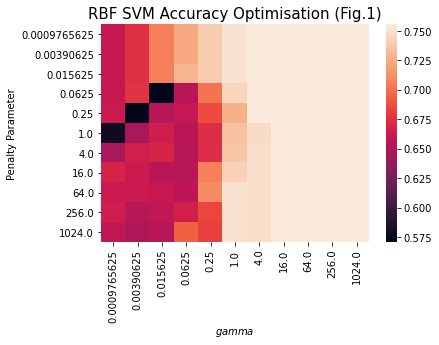

In [13]:
# a log range of gamma
gamma = 2.0**np.arange(-10,11,2)

# log range of the penalty parameter
C = 2.0**np.arange(-10,11,2) 

# 5-fold CV to find optimum hyperparamaters
_ = SVM(gamma, C, fig_num='1')

I will now perform a more refined searched of the optimal (white) region seen in Fig.1 

Best Score:  0.7584627638391078 
Best Parameters:  {'C': 2.0, 'gamma': 8.0}


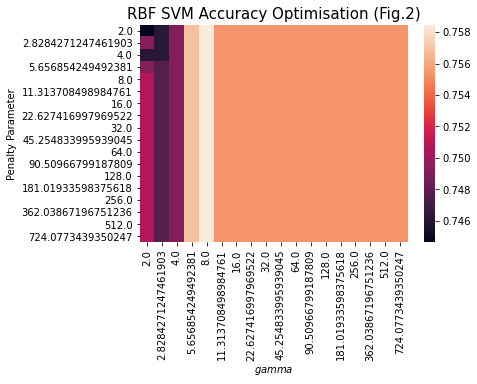

In [14]:
# a log range of gamma
gamma = 2.0**np.arange(1,10,0.5)

# log range of the penalty parameter
C = 2.0**np.arange(1,10,0.5) 

# 5-fold CV to find optimum hyperparamaters
RBF_CV = SVM(gamma, C, fig_num='2')

I will now evaluate the performance of the optimum model according to the cross-validation of accuracy.  

In [15]:
# the trained optimum model
clf = RBF_CV.best_estimator_

# the predictions of the model
y_pred = clf.predict(X)

# the mean score of the best parameters
print('Accuracy: ', clf.score(X, y))

# the recall of the predictions
print('Recall: ', recall_score(y, y_pred))

# good songs
good = np.count_nonzero(y_pred)
# bad songs
bad = len(y_pred) - good

# the predicted number of good and bad songs
print('Predicted number of good songs: ', good,
      '\nPredicted number of bad songs: ', bad)

Accuracy:  1.0
Recall:  1.0
Predicted number of good songs:  159 
Predicted number of bad songs:  491


Predictions on test set.

In [16]:
# the predictions of the model
y_pred = clf.predict(X_pred)

# good songs
good = np.count_nonzero(y_pred)
# bad songs
bad = len(y_pred) - good

# the predicted number of good and bad songs
print('Predicted number of good songs: ', good,
      '\nPredicted number of bad songs: ', bad)

Predicted number of good songs:  184 
Predicted number of bad songs:  2418


Assuming that the training set is representative of my song library (which with knowledge of my Liked songs it should roughly be) we can see that this models cross validation has suffered from overfitting this is likely down to an unbalanced dataset. To combat this and using knowledge of the cross validation I will know update the model parameters until they are predicting roughly 24% to be good songs and to have an accuracy above 98% on the test set.

In [17]:
ratios = []
accuracy = []
gammas = np.arange(1, 6, 0.01)
for gamma in gammas:
    clf = SVC(class_weight='balanced', gamma=gamma).fit(X, y)
    # the predictions of the model
    y_pred = clf.predict(X_pred)

    # good songs
    good = np.count_nonzero(y_pred)
    
    # good ratio
    ratio = good/len(y_pred)

    # add to ratios
    ratios.append(ratio)
    accuracy.append(clf.score(X, y))

# convert to array 
ratios = np.array(ratios)

# remove gammas with low accuracy
ratios[np.array(accuracy) < 0.98] = 1

# best remaining gamma
opt_gamma = gammas[np.argmin(np.abs(ratios-159/650))]
print('Optimum gamma: ', opt_gamma)

Optimum gamma:  2.260000000000001


Performance of new optimum model on the training data set.

In [18]:
# the trained optimum model
clf = SVC(class_weight='balanced', gamma=opt_gamma).fit(X, y)

# the predictions of the model
y_pred = clf.predict(X)

# the mean score of the best parameters
print('Accuracy: ', clf.score(X, y))

# the recall of the predictions
print('Recall: ', recall_score(y, y_pred))

# good songs
good = np.count_nonzero(y_pred)
# bad songs
bad = len(y_pred) - good

# the predicted number of good and bad songs
print('Predicted number of good songs: ', good,
      '\nPredicted number of bad songs: ', bad)

Accuracy:  0.98
Recall:  1.0
Predicted number of good songs:  172 
Predicted number of bad songs:  478


Predictions on the full dataset.

In [19]:
# the predictions of the model
y_pred = clf.predict(X_pred)

# good songs
good = np.count_nonzero(y_pred)
# bad songs
bad = len(y_pred) - good

# the predicted number of good and bad songs
print('Predicted number of good songs: ', good,
      '\nPredicted number of bad songs: ', bad)

Predicted number of good songs:  505 
Predicted number of bad songs:  2097


### Evaluation

It is clear that the best performing model is the SVM model so I will use that to make my predictions and hence create my playlist.

## Creating The Playlist

I will now create the playlist.

In [71]:
# ids of songs in the playlist
ids = scaled_df['id'][y_pred]

# create playlist
playlist = sp.user_playlist_create(username, name='SVM Running Playlist',
                                   public=False, description='')
# add songs
offset=0
while offset <= len(ids):
    songs = ids[offset:offset+100] 
    offset += 100
    sp.user_playlist_add_tracks(username, playlist['id'], songs)